In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
N_JOBS = 2

ARTIFACTS_DIR = Path("artifacts")
FIG_DIR = ARTIFACTS_DIR / "figures"

In [2]:
df = pd.read_csv("S06-hw-dataset-04.csv")
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [4]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


In [5]:
df.isna().sum().sort_values(ascending=False).head(20)

id     0
f01    0
f02    0
f03    0
f04    0
f05    0
f06    0
f07    0
f08    0
f09    0
f10    0
f11    0
f12    0
f13    0
f14    0
f15    0
f16    0
f17    0
f18    0
f19    0
dtype: int64

In [6]:
pd.DataFrame({
    "count": df["target"].value_counts(),
    "share": df["target"].value_counts(normalize=True)
})

,count,share
target,,
0,23770,0.9508
1,1230,0.0492


In [7]:
X = df.drop(columns=["target"])
if "id" in X.columns:
    X = X.drop(columns=["id"])
y = df["target"]

X.shape, y.shape

((25000, 60), (25000,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

pd.DataFrame({
    "train_share": y_train.value_counts(normalize=True),
    "test_share": y_test.value_counts(normalize=True),
    "train_count": y_train.value_counts(),
    "test_count": y_test.value_counts(),
})

,train_share,test_share,train_count,test_count
target,,,,
0,0.950773,0.95088,17827,5943
1,0.049227,0.04912,923,307


In [9]:
def evaluate_binary(model, X_test, y_test, name: str, save_figures: bool = True):
    y_pred = model.predict(X_test)

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "roc_auc": None,
        "avg_precision": None,
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion matrix — {name}")
    plt.tight_layout()
    if save_figures:
        plt.savefig(FIG_DIR / f"cm_{name}.png", dpi=150)
    plt.show()

    # ROC + PR only if probabilities available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics["roc_auc"] = float(roc_auc_score(y_test, y_proba))
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC — {name}")
        plt.tight_layout()
        if save_figures:
            plt.savefig(FIG_DIR / f"roc_{name}.png", dpi=150)
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        metrics["avg_precision"] = float(ap)

        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR curve (AP={ap:.4f}) — {name}")
        plt.tight_layout()
        if save_figures:
            plt.savefig(FIG_DIR / f"pr_{name}.png", dpi=150)
        plt.show()

    return metrics

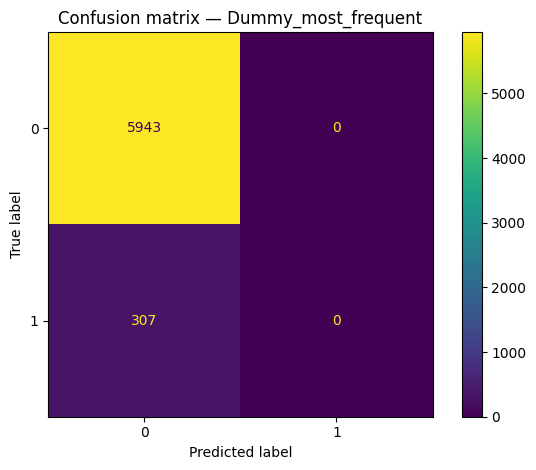

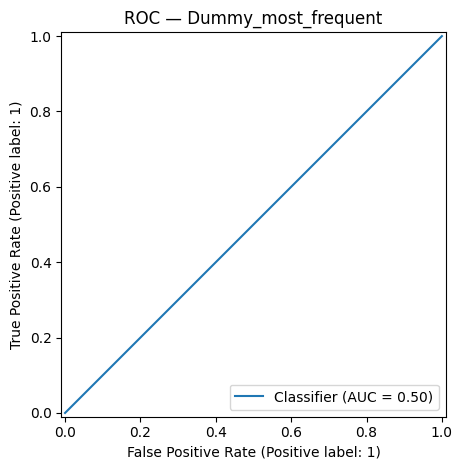

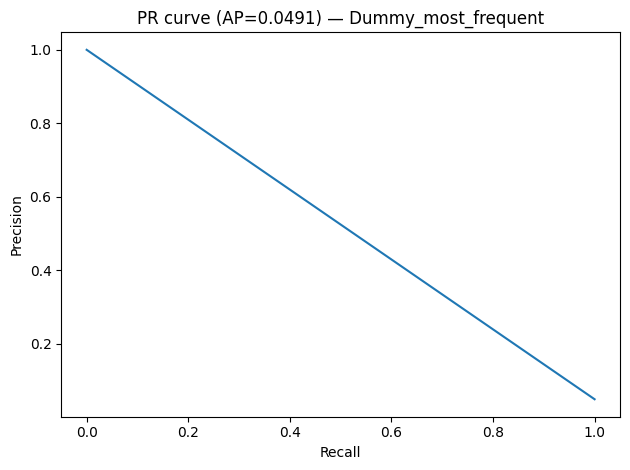

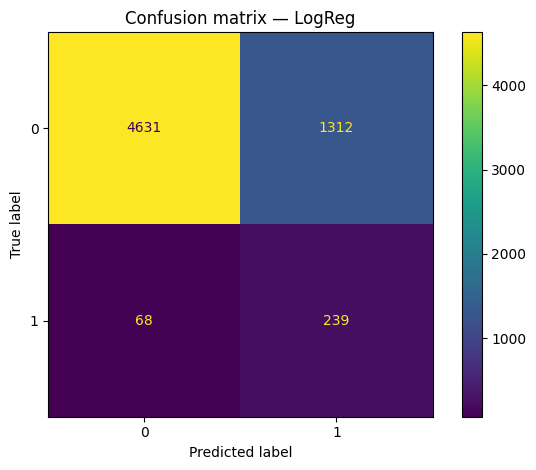

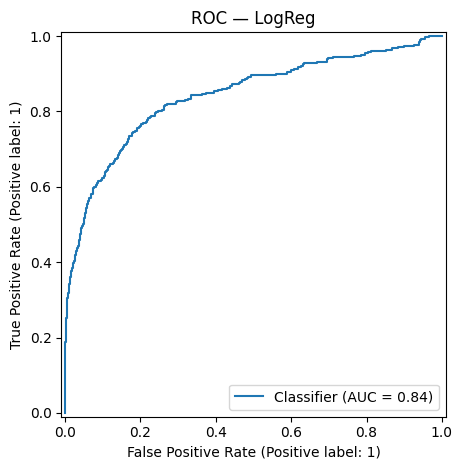

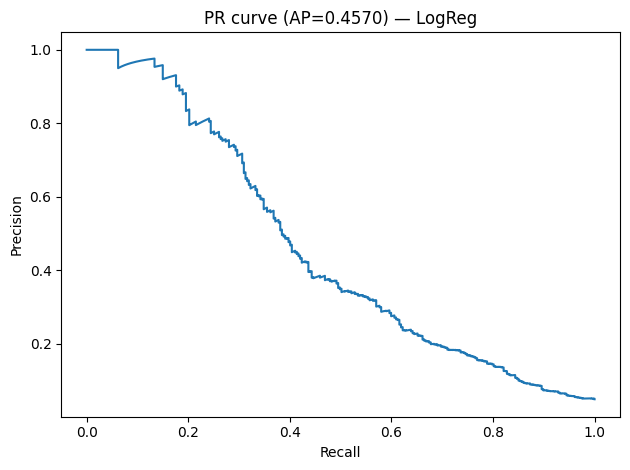

,accuracy,f1,roc_auc,avg_precision
LogReg,0.77920,0.257266,0.841861,0.457002
Dummy_most_frequent,0.95088,0.000000,0.500000,0.049120


In [10]:
results = {}
models = {}

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
models["Dummy_most_frequent"] = dummy
results["Dummy_most_frequent"] = evaluate_binary(dummy, X_test, y_test, "Dummy_most_frequent")

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=3000,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])
logreg.fit(X_train, y_train)
models["LogReg"] = logreg
results["LogReg"] = evaluate_binary(logreg, X_test, y_test, "LogReg")

pd.DataFrame(results).T.sort_values(["roc_auc", "avg_precision"], ascending=False)

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

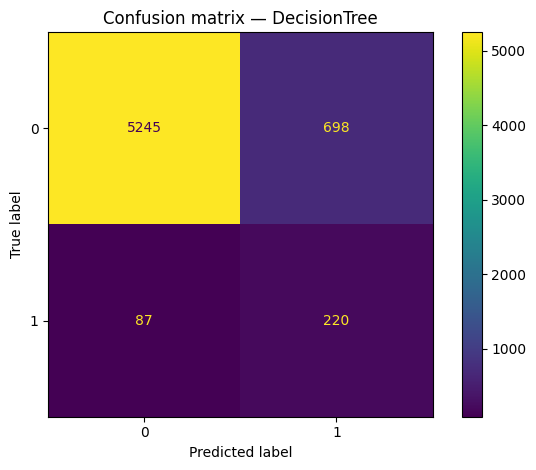

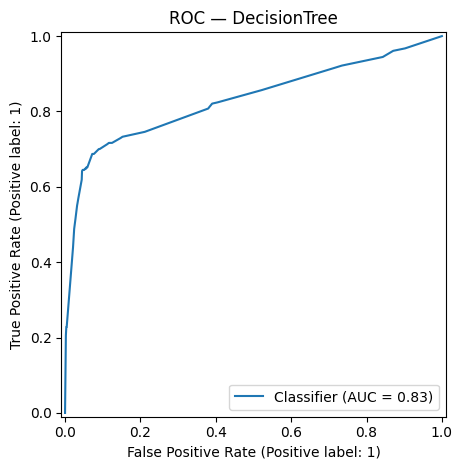

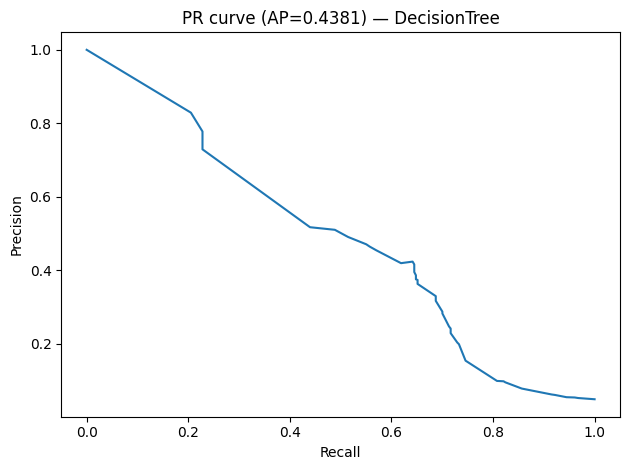

,accuracy,f1,roc_auc,avg_precision
LogReg,0.77920,0.257266,0.841861,0.457002
DecisionTree,0.87440,0.359184,0.830916,0.438113
Dummy_most_frequent,0.95088,0.000000,0.500000,0.049120


In [12]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")

tree_grid = {
    "max_depth": [2, 4, 6, None],
    "min_samples_leaf": [1, 5, 20],
}

tree_search = GridSearchCV(
    estimator=tree,
    param_grid=tree_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=N_JOBS
)
tree_search.fit(X_train, y_train)

best_tree = tree_search.best_estimator_
models["DecisionTree"] = best_tree
results["DecisionTree"] = evaluate_binary(best_tree, X_test, y_test, "DecisionTree")

pd.DataFrame(results).T.sort_values(["roc_auc", "avg_precision"], ascending=False)

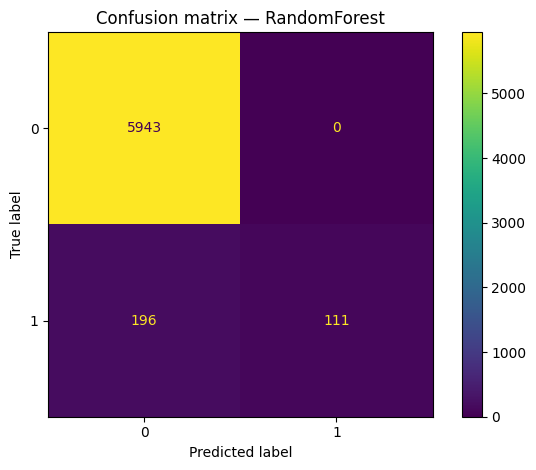

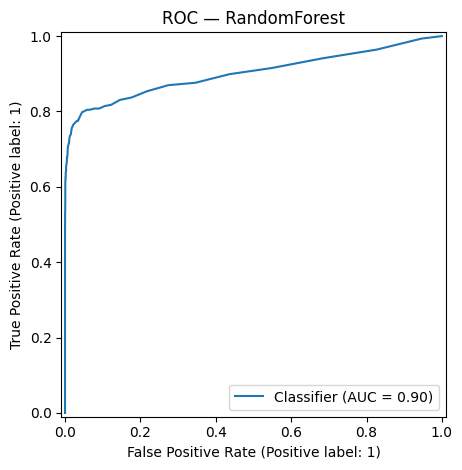

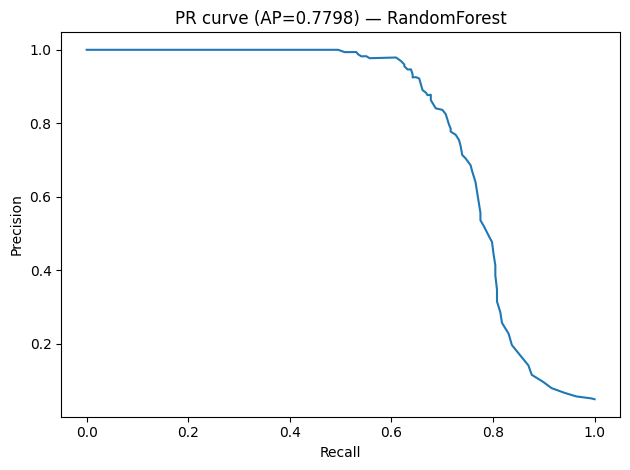

,accuracy,f1,roc_auc,avg_precision
RandomForest,0.96864,0.531100,0.901394,0.779752
LogReg,0.77920,0.257266,0.841861,0.457002
DecisionTree,0.87440,0.359184,0.830916,0.438113
Dummy_most_frequent,0.95088,0.000000,0.500000,0.049120


In [13]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight="balanced_subsample"
)

rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt"],
}

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=N_JOBS
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
models["RandomForest"] = best_rf
results["RandomForest"] = evaluate_binary(best_rf, X_test, y_test, "RandomForest")

pd.DataFrame(results).T.sort_values(["roc_auc", "avg_precision"], ascending=False)

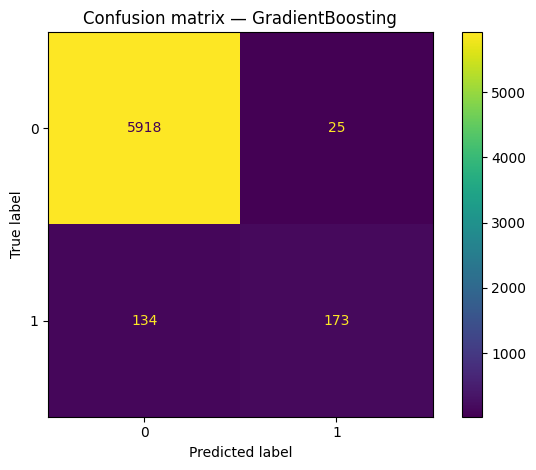

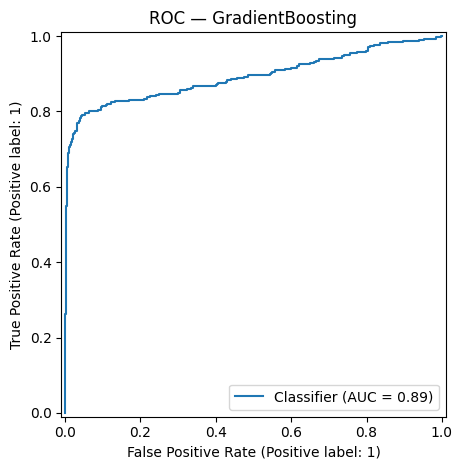

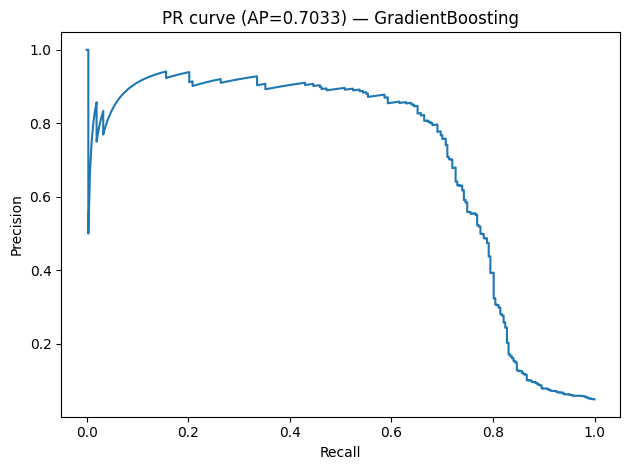

,accuracy,f1,roc_auc,avg_precision
RandomForest,0.96864,0.531100,0.901394,0.779752
GradientBoosting,0.97456,0.685149,0.892171,0.703275
LogReg,0.77920,0.257266,0.841861,0.457002
DecisionTree,0.87440,0.359184,0.830916,0.438113
Dummy_most_frequent,0.95088,0.000000,0.500000,0.049120


In [14]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
}

gb_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=N_JOBS
)
gb_search.fit(X_train, y_train)

best_gb = gb_search.best_estimator_
models["GradientBoosting"] = best_gb
results["GradientBoosting"] = evaluate_binary(best_gb, X_test, y_test, "GradientBoosting")

pd.DataFrame(results).T.sort_values(["roc_auc", "avg_precision"], ascending=False)

In [15]:
results_df = pd.DataFrame(results).T
results_df.sort_values(["roc_auc", "avg_precision"], ascending=False)

,accuracy,f1,roc_auc,avg_precision
RandomForest,0.96864,0.531100,0.901394,0.779752
GradientBoosting,0.97456,0.685149,0.892171,0.703275
LogReg,0.77920,0.257266,0.841861,0.457002
DecisionTree,0.87440,0.359184,0.830916,0.438113
Dummy_most_frequent,0.95088,0.000000,0.500000,0.049120


In [16]:
search_summaries = {
    "DecisionTree": {
        "best_params": tree_search.best_params_,
        "best_cv_score": float(tree_search.best_score_),
    },
    "RandomForest": {
        "best_params": rf_search.best_params_,
        "best_cv_score": float(rf_search.best_score_),
    },
    "GradientBoosting": {
        "best_params": gb_search.best_params_,
        "best_cv_score": float(gb_search.best_score_),
    },
}

pd.DataFrame({
    k: {"best_cv_score": v["best_cv_score"], **v["best_params"]}
    for k, v in search_summaries.items()
}).T


,best_cv_score,max_depth,min_samples_leaf,max_features,n_estimators,learning_rate
DecisionTree,0.816439,6.0,20.0,NaN,NaN,NaN
RandomForest,0.8943,None,1,sqrt,200,NaN
GradientBoosting,0.889582,3.0,NaN,NaN,200.0,0.1


In [17]:
ranking = results_df.copy()
ranking["roc_auc_filled"] = ranking["roc_auc"].fillna(-1)
ranking["avg_precision_filled"] = ranking["avg_precision"].fillna(-1)

best_name = ranking.sort_values(
    ["roc_auc_filled", "avg_precision_filled"],
    ascending=False
).index[0]

best_model = models[best_name]
best_name

'RandomForest'

In [18]:
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=5,  # облегчено
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

imp = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp.head(15)

,feature,importance_mean,importance_std
57,f58,0.010304,0.000412
52,f53,0.009664,0.000128
12,f13,0.007648,0.001058
46,f47,0.006752,0.000490
24,f25,0.005440,0.000859
53,f54,0.005344,0.001111
10,f11,0.004832,0.000988
37,f38,0.004480,0.000771
40,f41,0.003840,0.000000
56,f57,0.003456,0.000297


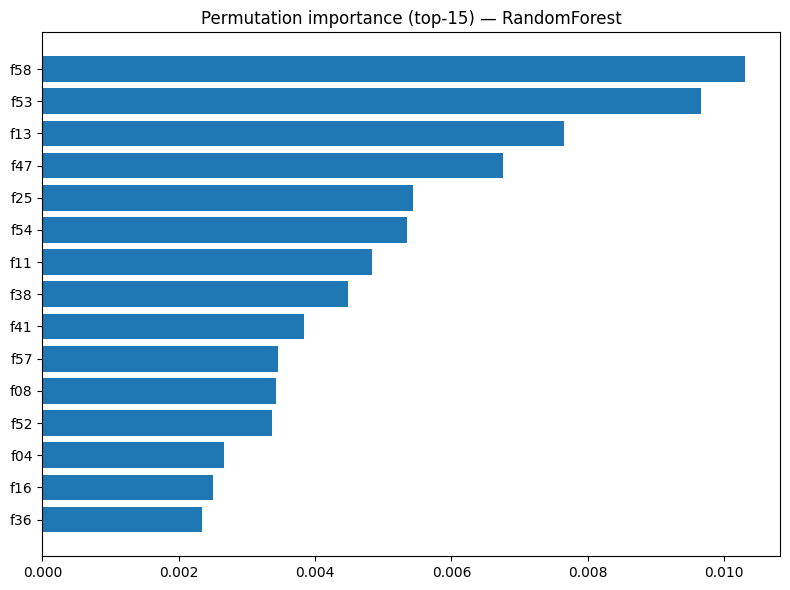

In [19]:
topn = 15
plot_df = imp.head(topn).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["importance_mean"])
plt.title(f"Permutation importance (top-{topn}) — {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"perm_importance_{best_name}.png", dpi=150)
plt.show()

In [20]:
with open(ARTIFACTS_DIR / "metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

with open(ARTIFACTS_DIR / "search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

joblib.dump(best_model, ARTIFACTS_DIR / "best_model.joblib")

best_model_meta = {
    "best_model_name": best_name,
    "selection_metric": "roc_auc (fallback: avg_precision)",
    "dataset": "S06-hw-dataset-04.csv",
    "random_state": RANDOM_STATE,
    "test_metrics": results[best_name],
    "best_params": search_summaries.get(best_name, {}).get("best_params", None),
}

with open(ARTIFACTS_DIR / "best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, ensure_ascii=False, indent=2)

best_model_meta

{'best_model_name': 'RandomForest',
 'selection_metric': 'roc_auc (fallback: avg_precision)',
 'dataset': 'S06-hw-dataset-04.csv',
 'random_state': 42,
 'test_metrics': {'accuracy': 0.96864,
  'f1': 0.5311004784688995,
  'roc_auc': 0.9013935865203692,
  'avg_precision': 0.7797520606678705},
 'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'n_estimators': 200}}

In [21]:
df.shape

(25000, 62)

In [22]:
df["target"].value_counts(normalize=True)

target
0    0.9508
1    0.0492
Name: proportion, dtype: float64